In [2]:
from transformers import pipeline


translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="mal_Mlym")
translator(["Hello, how are you?", "This is a test sentence."])

/Users/amaljoe/Desktop/Workspace/IITB/CS772/doctr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


KeyboardInterrupt: 

In [ ]:
import cv2
from doclayout_yolo import YOLOv10

# Load the pre-trained model
model = YOLOv10("../models/yolo.pt")

# Perform prediction
det_res = model.predict(
    "../data/mydata/flight.png",   # Image to predict
    imgsz=1024,        # Prediction image size
    conf=0.2,          # Confidence threshold
    device="mps"
)

# Annotate and save the result
annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
# cv2.imwrite("../outputs/mydata/flight.jpg", annotated_frame)


image 1/1 /Users/amaljoe/Desktop/Workspace/IITB/CS772/doctr/notebooks/../data/mydata/flight.png: 1024x864 10 titles, 18 plain texts, 6 abandons, 7 figures, 2 figure_captions, 68.2ms
Speed: 5.6ms preprocess, 68.2ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 864)


In [11]:
det_res[0].boxes

doclayout_yolo.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 1., 1., 1., 1., 1., 0., 2., 1., 1., 1., 0., 0., 0., 0., 3., 1., 3., 2., 4., 1., 2., 1., 0., 1., 3., 3., 0., 4., 0., 0., 1., 0., 1., 2., 3., 1., 2., 3., 1., 3., 2.], device='mps:0')
conf: tensor([0.9709, 0.9692, 0.9605, 0.9548, 0.9274, 0.9141, 0.9076, 0.8788, 0.8735, 0.8699, 0.8232, 0.7650, 0.7400, 0.7339, 0.7125, 0.6584, 0.6246, 0.5890, 0.5164, 0.5001, 0.4917, 0.4796, 0.4536, 0.4132, 0.4117, 0.3930, 0.3763, 0.3745, 0.3435, 0.3399, 0.3226, 0.3218, 0.3187, 0.3142, 0.2933, 0.2907, 0.2738, 0.2697, 0.2672,
        0.2493, 0.2389, 0.2261, 0.2219], device='mps:0')
data: tensor([[9.5873e+01, 4.7916e+02, 8.9492e+02, 5.7487e+02, 9.7088e-01, 1.0000e+00],
        [9.1297e+02, 5.8778e+02, 1.7155e+03, 7.1283e+02, 9.6919e-01, 1.0000e+00],
        [9.1156e+02, 4.7974e+02, 1.6788e+03, 5.7308e+02, 9.6051e-01, 1.0000e+00],
        [9.5202e+01, 5.8789e+02, 8.5892e+02, 6.5126e+02, 9.5480e-01, 1.0000e+00],
        [1.3676e+02,

In [ ]:
# Copyright (C) 2021-2025, Mindee.

# This program is licensed under the Apache License 2.0.
# See LICENSE or go to <https://opensource.org/licenses/Apache-2.0> for full license details.

import cv2
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import torch
from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor

from doctr.io import DocumentFile
from doctr.utils.visualization import visualize_page

forward_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def main(det_archs, reco_archs):
    """Build a streamlit layout"""
    # Wide mode
    st.set_page_config(layout="wide")

    # Designing the interface
    st.title("docTR: Document Text Recognition")
    # For newline
    st.write("\n")
    # Instructions
    st.markdown("*Hint: click on the top-right corner of an image to enlarge it!*")
    # Set the columns
    cols = st.columns((1, 1, 1, 1))
    cols[0].subheader("Input page")
    cols[1].subheader("Segmentation heatmap")
    cols[2].subheader("OCR output")
    cols[3].subheader("Page reconstitution")

    # Sidebar
    # File selection
    st.sidebar.title("Document selection")
    # Choose your own image
    uploaded_file = st.sidebar.file_uploader("Upload files", type=["pdf", "png", "jpeg", "jpg"])
    if uploaded_file is not None:
        if uploaded_file.name.endswith(".pdf"):
            doc = DocumentFile.from_pdf(uploaded_file.read())
        else:
            doc = DocumentFile.from_images(uploaded_file.read())
        page_idx = st.sidebar.selectbox("Page selection", [idx + 1 for idx in range(len(doc))]) - 1
        page = doc[page_idx]
        cols[0].image(page)

    # Model selection
    st.sidebar.title("Model selection")
    st.sidebar.markdown("**Backend**: PyTorch")
    det_arch = st.sidebar.selectbox("Text detection model", det_archs)
    reco_arch = st.sidebar.selectbox("Text recognition model", reco_archs)

    # For newline
    st.sidebar.write("\n")
    # Only straight pages or possible rotation
    st.sidebar.title("Parameters")
    assume_straight_pages = st.sidebar.checkbox("Assume straight pages", value=True)
    # Disable page orientation detection
    disable_page_orientation = st.sidebar.checkbox("Disable page orientation detection", value=False)
    # Disable crop orientation detection
    disable_crop_orientation = st.sidebar.checkbox("Disable crop orientation detection", value=False)
    # Straighten pages
    straighten_pages = st.sidebar.checkbox("Straighten pages", value=False)
    # Export as straight boxes
    export_straight_boxes = st.sidebar.checkbox("Export as straight boxes", value=False)
    st.sidebar.write("\n")
    # Binarization threshold
    bin_thresh = st.sidebar.slider("Binarization threshold", min_value=0.1, max_value=0.9, value=0.3, step=0.1)
    st.sidebar.write("\n")
    # Box threshold
    box_thresh = st.sidebar.slider("Box threshold", min_value=0.1, max_value=0.9, value=0.1, step=0.1)
    st.sidebar.write("\n")

    if st.sidebar.button("Analyze page"):
        if uploaded_file is None:
            st.sidebar.write("Please upload a document")

        else:
            with st.spinner("Loading model..."):
                predictor = load_predictor(
                    det_arch=det_arch,
                    reco_arch=reco_arch,
                    assume_straight_pages=assume_straight_pages,
                    straighten_pages=straighten_pages,
                    export_as_straight_boxes=export_straight_boxes,
                    disable_page_orientation=disable_page_orientation,
                    disable_crop_orientation=disable_crop_orientation,
                    bin_thresh=bin_thresh,
                    box_thresh=box_thresh,
                    device=forward_device,
                )

            with st.spinner("Analyzing..."):
                # Forward the image to the model
                seg_map = forward_image(predictor, page, forward_device)
                seg_map = np.squeeze(seg_map)
                seg_map = cv2.resize(seg_map, (page.shape[1], page.shape[0]), interpolation=cv2.INTER_LINEAR)

                # Plot the raw heatmap
                fig, ax = plt.subplots()
                ax.imshow(seg_map)
                ax.axis("off")
                cols[1].pyplot(fig)

                # Plot OCR output
                out = predictor([page])
                fig = visualize_page(out.pages[0].export(), out.pages[0].page, interactive=False, add_labels=False)
                cols[2].pyplot(fig)

                # Page reconsitution under input page
                page_export = out.pages[0].export()
                if assume_straight_pages or (not assume_straight_pages and straighten_pages):
                    img = out.pages[0].synthesize()
                    cols[3].image(img, clamp=True)

                # Display JSON
                st.markdown("\nHere are your analysis results in JSON format:")
                st.json(page_export, expanded=False)


if __name__ == "__main__":
    main(DET_ARCHS, RECO_ARCHS)


In [27]:

from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor
from doctr.io import DocumentFile
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import torch
from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor
from doctr.utils.visualization import visualize_page


doc_path = "../data/mydata/flight.png"
if doc_path.endswith((".pdf", ".PDF")):
    doc = DocumentFile.from_pdf(doc_path)
else:
    doc = DocumentFile.from_images(doc_path)
page = doc[0]

forward_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictor = load_predictor(
    det_arch=DET_ARCHS[0],
    reco_arch=RECO_ARCHS[0],
    assume_straight_pages=True,
    straighten_pages=False,
    export_as_straight_boxes=False,
    disable_page_orientation=False,
    disable_crop_orientation=False,
    bin_thresh=0.3,
    box_thresh=0.1,
    device=forward_device,
)

# Forward the image to the model
seg_map = forward_image(predictor, page, forward_device)
seg_map = np.squeeze(seg_map)
seg_map = cv2.resize(seg_map, (page.shape[1], page.shape[0]), interpolation=cv2.INTER_LINEAR)

# Run OCR
out = predictor([page])
page_export = out.pages[0].export()
img = out.pages[0].synthesize()

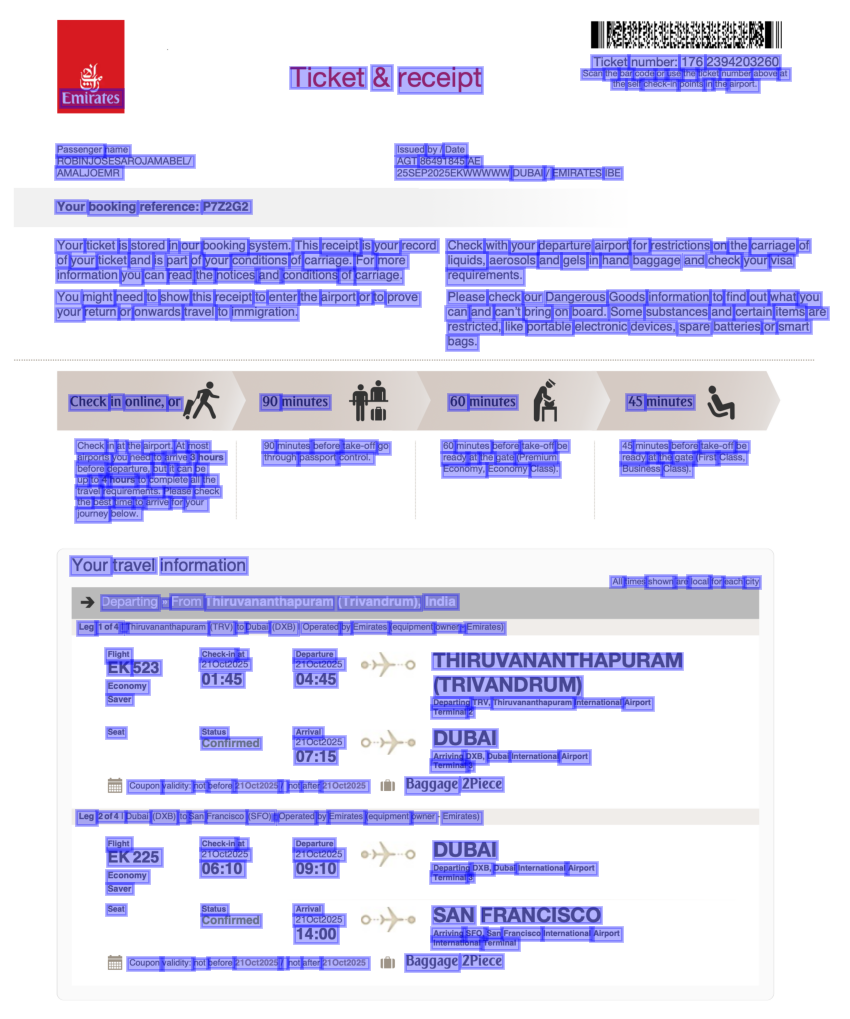

In [5]:
vis = visualize_page(out.pages[0].export(), out.pages[0].page, interactive=False, add_labels=False)


0: 1024x864 10 titles, 18 plain texts, 6 abandons, 7 figures, 2 figure_captions, 73.1ms
Speed: 5.4ms preprocess, 73.1ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 864)


(np.float64(-0.5), np.float64(1739.5), np.float64(2095.5), np.float64(-0.5))

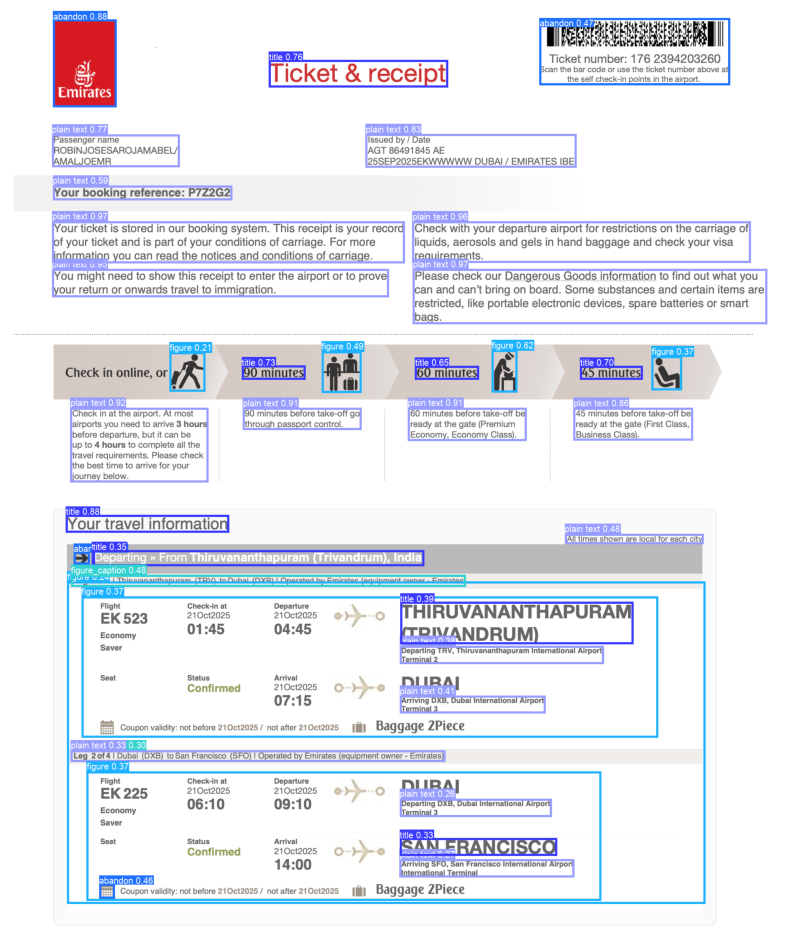

In [10]:
import cv2
from doclayout_yolo import YOLOv10

# Load the pre-trained model
model = YOLOv10("../models/yolo.pt")

# Perform prediction
det_res = model.predict(
    page,   # Image to predict
    imgsz=1024,        # Prediction image size
    conf=0.2,          # Confidence threshold
    device="mps"
)

# Annotate and save the result
annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
plt.figure(figsize=(12, 12))
plt.imshow(annotated_frame)
plt.axis("off")

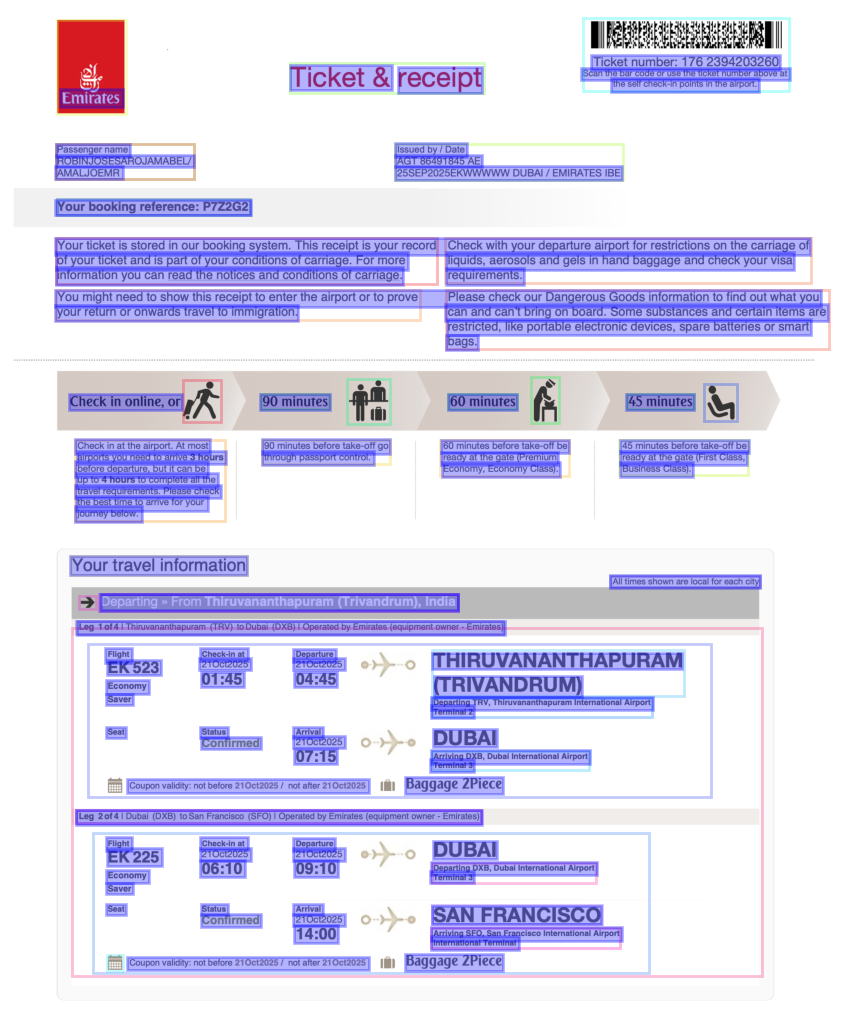

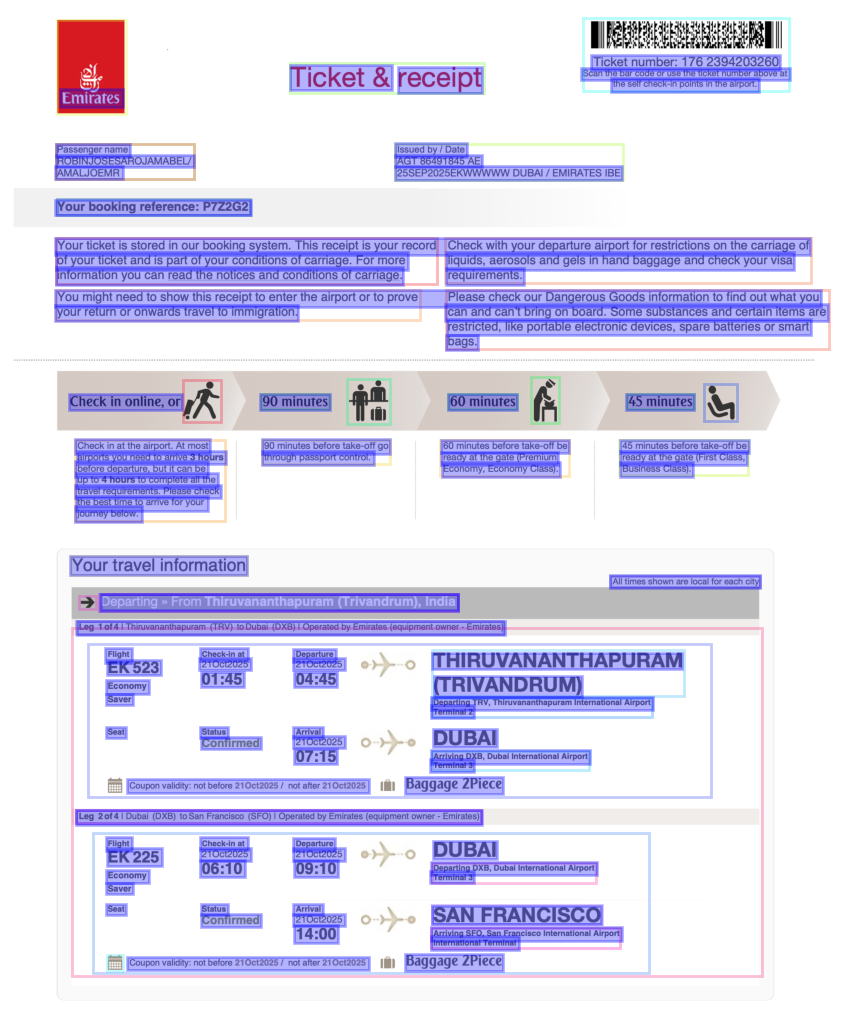

In [11]:
visualize_page(combined_page_export, out.pages[0].page, interactive=False, add_labels=False, boxes=det_res[0].boxes.xyxyn)

In [ ]:
def box_area(box):
    # box = [x1, y1, x2, y2]
    return max(0, box[2] - box[0]) * max(0, box[3] - box[1])

def intersection_area(line_box, big_box):
    x1 = max(line_box[0][0], big_box[0])
    y1 = max(line_box[0][1], big_box[1])
    x2 = min(line_box[1][0], big_box[2])
    y2 = min(line_box[1][1], big_box[3])

    if x2 <= x1 or y2 <= y1:
        return 0
    return (x2 - x1) * (y2 - y1)


big_boxes = det_res[0].boxes.xyxyn.tolist()
big_boxes_children = [[] for _ in big_boxes]

for line in page_export['blocks'][0]['lines']:
    line_box = line['geometry']
    line_area = box_area([line_box[0][0], line_box[0][1], line_box[1][0], line_box[1][1]])
    
    best_match = None
    best_overlap_ratio = 0
    
    for i, box in enumerate(big_boxes):
        inter_area = intersection_area(line_box, box)
        overlap_ratio = inter_area / (line_area + 1e-8)

        # If 75% or more of the line lies inside the box, choose this box
        if overlap_ratio >= 0.75 and overlap_ratio > best_overlap_ratio:
            best_overlap_ratio = overlap_ratio
            best_match = i
    
    if best_match is not None:
        big_boxes_children[best_match].append(line)
    else:
        for word in line['words']:
            line_box = word['geometry']
            line_area = box_area([line_box[0][0], line_box[0][1], line_box[1][0], line_box[1][1]])
            
            best_match = None
            best_overlap_ratio = 0
            
            for i, box in enumerate(big_boxes):
                inter_area = intersection_area(line_box, box)
                overlap_ratio = inter_area / (line_area + 1e-8)

                # If 75% or more of the line lies inside the box, choose this box
                if overlap_ratio >= 0.75 and overlap_ratio > best_overlap_ratio:
                    best_overlap_ratio = overlap_ratio
                    best_match = i
            
            if best_match is not None:
                big_boxes_children[best_match].append(word)
            else:
                print("No 75% match:", word)

big_boxes

No 75% match: {'value': 'Check', 'confidence': 0.9977310299873352, 'geometry': ((np.float64(0.07062679597701149), np.float64(0.3857421875)), (np.float64(0.11885775862068965), np.float64(0.400390625))), 'objectness_score': 0.7614503502845764, 'crop_orientation': {'value': 0, 'confidence': None}}
No 75% match: {'value': 'in', 'confidence': 0.9993526339530945, 'geometry': ((np.float64(0.11885775862068965), np.float64(0.384765625)), (np.float64(0.13532686781609193), np.float64(0.3994140625))), 'objectness_score': 0.7371227741241455, 'crop_orientation': {'value': 0, 'confidence': None}}
No 75% match: {'value': 'online,', 'confidence': 0.5804396867752075, 'geometry': ((np.float64(0.1365032327586207), np.float64(0.3857421875)), (np.float64(0.18826329022988508), np.float64(0.400390625))), 'objectness_score': 0.8073570728302002, 'crop_orientation': {'value': 0, 'confidence': None}}
No 75% match: {'value': 'or', 'confidence': 0.9933933615684509, 'geometry': ((np.float64(0.18826329022988508), np.

[[0.05510441213846207,
  0.2286098599433899,
  0.5143166780471802,
  0.2742682099342346],
 [0.5246937870979309,
  0.28042903542518616,
  0.985930860042572,
  0.34008440375328064],
 [0.5238882303237915,
  0.22887909412384033,
  0.9648398160934448,
  0.2734145522117615],
 [0.05471435934305191,
  0.28048428893089294,
  0.49362894892692566,
  0.3107115924358368],
 [0.07859154045581818,
  0.43039751052856445,
  0.258512407541275,
  0.5112802982330322],
 [0.517996609210968,
  0.4305751323699951,
  0.6728062629699707,
  0.4663151502609253],
 [0.30317941308021545,
  0.4306912124156952,
  0.4575086534023285,
  0.4546281397342682],
 [0.07298845797777176,
  0.5463610887527466,
  0.2851826250553131,
  0.5655773878097534],
 [0.056168992072343826,
  0.010262742638587952,
  0.13884741067886353,
  0.10524237155914307],
 [0.7338418960571289,
  0.43078041076660156,
  0.8892590999603271,
  0.46583425998687744],
 [0.46320948004722595,
  0.1343667209148407,
  0.7375822067260742,
  0.17072954773902893],
 [0

In [ ]:
def box_area(box):
    # box = [x1, y1, x2, y2]
    return max(0, box[2] - box[0]) * max(0, box[3] - box[1])

def intersection_area(line_box, big_box):
    x1 = max(line_box[0][0], big_box[0])
    y1 = max(line_box[0][1], big_box[1])
    x2 = min(line_box[1][0], big_box[2])
    y2 = min(line_box[1][1], big_box[3])

    if x2 <= x1 or y2 <= y1:
        return 0
    return (x2 - x1) * (y2 - y1)


big_boxes = det_res[0].boxes.xyxyn.tolist()
big_boxes_children = [[] for _ in big_boxes]

for line in page_export['blocks'][0]['lines']:
    for word in line['words']:
        line_box = word['geometry']
        line_area = box_area([line_box[0][0], line_box[0][1], line_box[1][0], line_box[1][1]])
        
        best_match = None
        best_overlap_ratio = 0
        
        for i, box in enumerate(big_boxes):
            inter_area = intersection_area(line_box, box)
            overlap_ratio = inter_area / (line_area + 1e-8)

            # If 75% or more of the line lies inside the box, choose this box
            if overlap_ratio >= 0.75 and overlap_ratio > best_overlap_ratio:
                best_overlap_ratio = overlap_ratio
                best_match = i
        
        if best_match is not None:
            big_boxes_children[best_match].append(line)
        else:
            print("No 75% match:", word)

big_boxes

In [ ]:
orig_lines = page_export['blocks'][0]['lines']
new_lines = []

[{'geometry': ((np.float64(0.6999820402298851), np.float64(0.0458984375)),
   (np.float64(0.9270204741379311), np.float64(0.060546875))),
  'objectness_score': 0.7845475375652313,
  'words': [{'value': 'Ticket number: 176 2394203260',
    'confidence': 0.9789448976516724,
    'geometry': ((np.float64(0.6999820402298851), np.float64(0.0458984375)),
     (np.float64(0.9270204741379311), np.float64(0.060546875))),
    'objectness_score': 0.7845475375652313,
    'crop_orientation': {'value': 0, 'confidence': None}}]},
 {'geometry': ((np.float64(0.3364852729885057), np.float64(0.0556640625)),
   (np.float64(0.46000359195402296), np.float64(0.0810546875))),
  'objectness_score': 0.8293601870536804,
  'words': [{'value': 'Ticket &',
    'confidence': 0.9955938458442688,
    'geometry': ((np.float64(0.3364852729885057), np.float64(0.0556640625)),
     (np.float64(0.46000359195402296), np.float64(0.0810546875))),
    'objectness_score': 0.8293601870536804,
    'crop_orientation': {'value': 0, '

In [136]:
det_res[0].boxes.xyxyn

tensor([[0.0551, 0.2286, 0.5143, 0.2743],
        [0.5247, 0.2804, 0.9859, 0.3401],
        [0.5239, 0.2289, 0.9648, 0.2734],
        [0.0547, 0.2805, 0.4936, 0.3107],
        [0.0786, 0.4304, 0.2585, 0.5113],
        [0.5180, 0.4306, 0.6728, 0.4663],
        [0.3032, 0.4307, 0.4575, 0.4546],
        [0.0730, 0.5464, 0.2852, 0.5656],
        [0.0562, 0.0103, 0.1388, 0.1052],
        [0.7338, 0.4308, 0.8893, 0.4658],
        [0.4632, 0.1344, 0.7376, 0.1707],
        [0.0547, 0.1346, 0.2209, 0.1702],
        [0.3373, 0.0542, 0.5705, 0.0838],
        [0.3017, 0.3850, 0.3846, 0.4000],
        [0.7424, 0.3851, 0.8240, 0.4001],
        [0.5274, 0.3853, 0.6107, 0.3999],
        [0.6272, 0.3682, 0.6606, 0.4141],
        [0.0559, 0.1899, 0.2893, 0.2057],
        [0.4058, 0.3694, 0.4579, 0.4145],
        [0.7225, 0.5668, 0.9031, 0.5779],
        [0.0794, 0.6115, 0.5937, 0.6244],
        [0.6896, 0.0088, 0.9376, 0.0814],
        [0.1163, 0.9456, 0.1363, 0.9616],
        [0.5075, 0.7422, 0.6974, 0

(np.float64(-0.5), np.float64(1739.5), np.float64(2095.5), np.float64(-0.5))

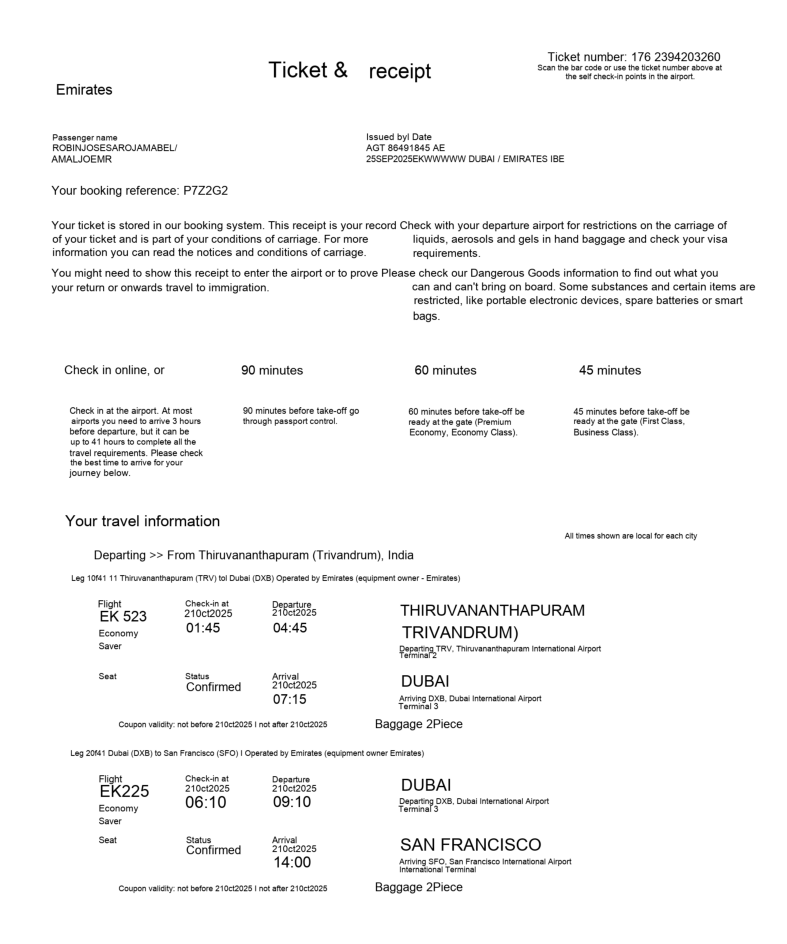

In [8]:
# for line in out.pages[0].blocks[0].lines:
#    for word in line.words:
#        print(word.value)

page_export['blocks'][0]['lines']

def combine_words_in_lines(page_export):
    page_export = page_export.copy()
    for block in page_export['blocks']:
        for line in block['lines']:
            combined_value = ' '.join([word['value'] for word in line['words']])
            line['words'] = [line['words'][0]]  # Keep only the first word's metadata
            line['words'][0]['value'] = combined_value  # Update the value to the
            line['words'][0]['geometry'] = line['geometry']  # Update geometry to line's geometry
            line['words'][0]['objectness_score'] = line['objectness_score']  # Set objectness score
    return page_export

combined_page_export = combine_words_in_lines(page_export)


from doctr.utils.reconstitution import synthesize_page
syn = synthesize_page(combined_page_export)
plt.figure(figsize=(12, 12))
plt.imshow(syn)
plt.axis('off')

In [122]:
page_export = page_export.copy()
values = []
for block in page_export['blocks']:
    for line in block['lines']:
        for word in line['words']:
            values.append(word['value'])
page_export

{'page_idx': 0,
 'dimensions': (2096, 1740),
 'orientation': {'value': None, 'confidence': None},
 'language': {'value': None, 'confidence': None},
 'blocks': [{'geometry': ((np.float64(0.054157686781609204),
     np.float64(0.0458984375)),
    (np.float64(0.9846623563218391), np.float64(0.9619140625))),
   'objectness_score': 0.7651482421066125,
   'lines': [{'geometry': ((np.float64(0.6999820402298851),
       np.float64(0.0458984375)),
      (np.float64(0.9270204741379311), np.float64(0.060546875))),
     'objectness_score': 0.7845475375652313,
     'words': [{'value': 'Ticket number: 176 2394203260',
       'confidence': 0.9789448976516724,
       'geometry': ((np.float64(0.6999820402298851), np.float64(0.0458984375)),
        (np.float64(0.9270204741379311), np.float64(0.060546875))),
       'objectness_score': 0.7845475375652313,
       'crop_orientation': {'value': 0, 'confidence': None}}]},
    {'geometry': ((np.float64(0.3364852729885057), np.float64(0.0556640625)),
      (np.

In [1]:
page_export

NameError: name 'page_export' is not defined

In [33]:
from transformers import pipeline


translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="mal_Mlym")
translator(["Hello, how are you?", "This is a test sentence.", "Ticket number", "check in online, or"])

Device set to use mps:0


[{'translation_text': 'ഹലോ, എങ്ങിനെ പോകുന്നു?'},
 {'translation_text': 'ഇത് ഒരു പരീക്ഷണ വാക്യമാണ്.'},
 {'translation_text': 'ടിക്കറ്റ് നമ്പർ'},
 {'translation_text': 'ഓൺലൈനായി ചെക്ക് ഇൻ ചെയ്യുക; അല്ലെങ്കിൽ'}]

(np.float64(-0.5), np.float64(1739.5), np.float64(2095.5), np.float64(-0.5))

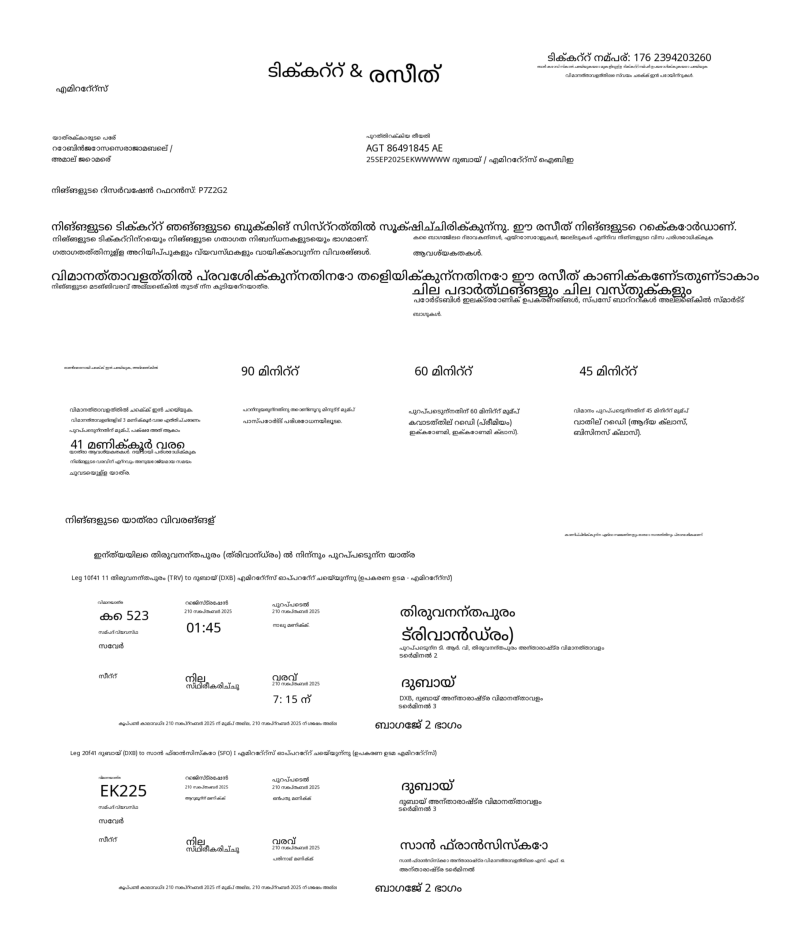

In [124]:

def translate(page_export):
    page_export = page_export.copy()
    values = []
    for block in page_export['blocks']:
        for line in block['lines']:
            for word in line['words']:
                values.append(word['value'])
    translations = translator(values)
    for i, block in enumerate(page_export['blocks']):
        for j, line in enumerate(block['lines']):
            for k, word in enumerate(line['words']):
                word['value'] = translations.pop(0)['translation_text']
    return page_export

translated_page_export = translate(combined_page_export)
syn = synthesize_page(translated_page_export, font_family='../fonts/noto-mal.ttf')
plt.figure(figsize=(12, 12))
plt.imshow(syn)
plt.axis('off')

In [125]:
translated_page_export

{'page_idx': 0,
 'dimensions': (2096, 1740),
 'orientation': {'value': None, 'confidence': None},
 'language': {'value': None, 'confidence': None},
 'blocks': [{'geometry': ((np.float64(0.054157686781609204),
     np.float64(0.0458984375)),
    (np.float64(0.9846623563218391), np.float64(0.9619140625))),
   'objectness_score': 0.7651482421066125,
   'lines': [{'geometry': ((np.float64(0.6999820402298851),
       np.float64(0.0458984375)),
      (np.float64(0.9270204741379311), np.float64(0.060546875))),
     'objectness_score': 0.7845475375652313,
     'words': [{'value': 'ടിക്കറ്റ് നമ്പര്: 176 2394203260',
       'confidence': 0.9789448976516724,
       'geometry': ((np.float64(0.6999820402298851), np.float64(0.0458984375)),
        (np.float64(0.9270204741379311), np.float64(0.060546875))),
       'objectness_score': 0.7845475375652313,
       'crop_orientation': {'value': 0, 'confidence': None}}]},
    {'geometry': ((np.float64(0.3364852729885057), np.float64(0.0556640625)),
      (

In [128]:
values[:1], translator(values[:1])

(['Ticket number: 176 2394203260'],
 [{'translation_text': 'ടിക്കറ്റ് നമ്പര്: 176 2394203260'}])

In [131]:
translator(['Ticket number'])

[{'translation_text': 'ടിക്കറ്റ് നമ്പർ'}]

In [112]:
import matplotlib.font_manager as fm
font_family = fm.findfont("Noto Sans")
font_family

'/Users/amaljoe/Desktop/Workspace/IITB/CS772/doctr/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [113]:
for f in fm.findSystemFonts(fontext='ttf'):
    if "malayalam" in f.lower():
        print(f)

/System/Library/Fonts/Supplemental/Malayalam MN.ttc
/System/Library/AssetsV2/com_apple_MobileAsset_Font7/25f6134c89b011288b72c7b81c9c22b2d6882471.asset/AssetData/SamaMalayalam.ttc
/System/Library/Fonts/Supplemental/Malayalam Sangam MN.ttc
/System/Library/AssetsV2/com_apple_MobileAsset_Font7/5a224f093c7ff58ae98872248e5938769301bb72.asset/AssetData/BalooChettanMalayalam.ttc


In [ ]:
from doctr.utils.visualization import visualize_page

# --- PLOT ALL 3 IN A SINGLE FIGURE ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1) Raw segmentation heatmap
axs[0].imshow(seg_map, cmap='inferno')
axs[0].set_title("Segmentation Heatmap")
axs[0].axis("off")

# 2) OCR result visualization
axs[1].imshow(ocr_vis)
axs[1].set_title("OCR Visualization")
axs[1].axis("off")

# 3) Synthesized page
axs[2].imshow(img)
axs[2].set_title("Reconstructed Page")
axs[2].axis("off")

plt.tight_layout()
plt.show()

array([[          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       ...,
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0],
       [          0,           0,           0, ...,           0,           0,           0]], shape=(2096, 1740), dtype=float32)